# Import Modules

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import typing as tp
import time
import random

import torch
from torch import nn, Tensor

# Ops

In [2]:
def plot_environment(env:gym.Env, figsize:tuple[int, int]=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames:list, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animation = anim.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    return animation

def show_one_episode(action_sampler:tp.Callable, n_max_steps=500, repeat=False):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset()
    with torch.no_grad():
        for step in range(n_max_steps):
            frames.append(env.render())
            action = action_sampler(obs)
            obs, reward, done, truncated, info = env.step(action)
            if done or truncated:
                print("done at step", step)
                break
    env.close()
    return plot_animation(frames, repeat=repeat)

# Cartpole Environment
* GOAL: Keep the pole upright for as long as possible
```python
Actions:
    left: 0
    right: 1

Observation Space: (4,)
```
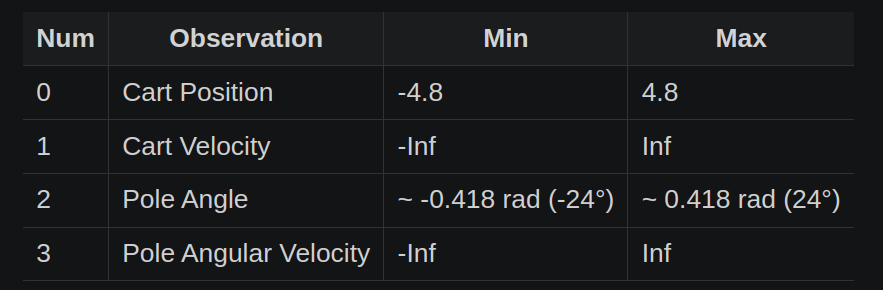
* The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
* The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)

## Rewards
* Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted

## Episode End
* The episode ends if any one of the following occurs:
    * Termination: Pole Angle is greater than ±12°
    * Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    * Truncation: Episode length is greater than 500

In [3]:
class config:
    num_iters:int = 800
    num_episodes_per_iter:int = 10
    max_steps_per_episode:int = 500
    
    gamma:float = 0.95
    
    lr:float = 0.01
    weight_decay:float = 0.0

    device:torch.device = torch.device("cuda" if False else "cpu")
    dtype:torch.dtype = torch.float16 if "cpu" in device.type else torch.float32

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=1)
obs, obs.shape, info

(array([ 0.00118216,  0.04504637, -0.03558404,  0.04486495], dtype=float32),
 (4,),
 {})

In [5]:
class Policy(nn.Module):
    def __init__(self, num_inputs:int, num_hidden:int, num_outputs:int):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.last_act_func = nn.Sigmoid() if num_outputs == 1 else nn.Softmax(dim=-1)

    def forward(self, x:Tensor): # (B, num_inputs=4)
        x = self.relu(self.linear1(x)) # (B, num_hidden=8)
        x = self.last_act_func(self.linear2(x)) # (B, num_outputs=1)
        return x

In [6]:
pi = Policy(
    num_inputs=env.observation_space.shape[0], # 4
    num_hidden=env.observation_space.shape[0]*2, # 8
    num_outputs=1 if env.action_space.n == 2 else env.action_space.n, #  (left, right)
)
pi.to(config.device)
optimizer = torch.optim.NAdam(pi.parameters(), lr=config.lr, weight_decay=config.weight_decay)
autocast = torch.autocast(device_type=config.device.type, dtype=config.dtype)
print(pi, sum(p.numel() for p in pi.parameters()), sep="\nNumber of parameters: ")

Policy(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=8, out_features=1, bias=True)
  (last_act_func): Sigmoid()
)
Number of parameters: 49


In [7]:
@torch.compile
def loss_fn(pi:Policy, obs:Tensor) -> tuple[Tensor, Tensor]:
    left_proba = pi(obs.unsqueeze(0)) # (1, 1)
    action = torch.rand(size=(1, 1), device=config.device) > left_proba # If `left_proba` is high, then `action` will most likely be `False` or 0, which means left
    y_target = 1.0 if action==False else 0.0  # If `action` is left, then `y_target` will be 1.0 
    loss = -(torch.log(left_proba) * y_target + torch.log(1.0 - left_proba) * (1.0 - y_target))
    return loss.mean(), action

def play_one_episode(
    env:gym.Env,
    pi:Policy,
    obs:np.ndarray,
):
    obs = torch.as_tensor(obs, device=config.device)
    with autocast:
        loss, action_taken = loss_fn(pi, obs)
    loss.backward()
    grads = [p.grad for p in pi.parameters()]; pi.zero_grad()
    action_taken = int(action_taken.item())
    obs, reward, done, truncated, info = env.step(action_taken)
    return (obs, reward, done, truncated), (loss, grads)

def discount_rewards(rewards:np.ndarray|list, gamma:float):
    running_add = 0
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    for t in reversed(range(len(rewards))):
        running_add = rewards[t] + running_add * gamma
        discounted_rewards[t] = running_add
    return discounted_rewards

def apply_grads(grads:list[list[Tensor]], rewards:list[list[Tensor]]):
    param_list_len = len([p for p in pi.parameters()])
    to_be_applied_grads:list[list[Tensor]] = [[] for _ in range(param_list_len)] # initialize list

    for n_ep_per_iter, grads_in_ep in enumerate(grads):
        for step, grads_in_step in enumerate(grads_in_ep):
            for i, grad in enumerate(grads_in_step):
                to_be_applied_grads[i].append(grad*rewards[n_ep_per_iter][step])

    grads:list[Tensor] = [torch.stack(grad_list).mean(dim=0) for grad_list in to_be_applied_grads]
    
    for p, grad in zip(pi.parameters(), grads):
        p.grad = grad

    optimizer.step()
    optimizer.zero_grad()

In [8]:
def play():
    episode_length_avgs = []
    for iter_num in range(1, config.num_iters+1):
        t0 = time.time()
        all_rewards, all_grads = [], []
        for episode in range(config.num_episodes_per_iter):
            current_grads, current_rewards = [], []
            obs, info = env.reset()
            for step in range(config.max_steps_per_episode):
                (
                    (obs, reward, done, truncated), (loss, grads)
                ) = play_one_episode(env, pi, obs)
                current_grads.append(grads); current_rewards.append(reward)
                if done or truncated:
                    break
            
            all_rewards.append(current_rewards); all_grads.append(current_grads)
        t1 = time.time(); dt = t1-t0
        episode_len_avg = sum(map(len, all_rewards))/config.num_episodes_per_iter; episode_length_avgs.append(episode_len_avg)
        print(f"| Step: {iter_num}/{config.num_iters} || Average Episode Length {episode_len_avg:.2f} || dt: {dt:.2f}s |")

        all_rewards = list(map(lambda r:discount_rewards(r, config.gamma), all_rewards))

        flattened_rewards = np.concatenate(all_rewards)
        all_rewards = [r - flattened_rewards.mean()/ flattened_rewards.std() for r in all_rewards]
        apply_grads(all_grads, all_rewards)
    return episode_length_avgs

avg_episode_lengths = play()

| Step: 1/800 || Average Episode Length 18.90 || dt: 2.76s |
| Step: 2/800 || Average Episode Length 24.20 || dt: 0.03s |
| Step: 3/800 || Average Episode Length 29.30 || dt: 0.04s |
| Step: 4/800 || Average Episode Length 24.60 || dt: 0.03s |
| Step: 5/800 || Average Episode Length 21.70 || dt: 0.03s |
| Step: 6/800 || Average Episode Length 23.10 || dt: 0.03s |
| Step: 7/800 || Average Episode Length 17.90 || dt: 0.03s |
| Step: 8/800 || Average Episode Length 24.70 || dt: 0.04s |
| Step: 9/800 || Average Episode Length 23.40 || dt: 0.04s |
| Step: 10/800 || Average Episode Length 22.40 || dt: 0.03s |
| Step: 11/800 || Average Episode Length 24.70 || dt: 0.04s |
| Step: 12/800 || Average Episode Length 18.70 || dt: 0.03s |
| Step: 13/800 || Average Episode Length 19.00 || dt: 0.03s |
| Step: 14/800 || Average Episode Length 25.70 || dt: 0.04s |
| Step: 15/800 || Average Episode Length 17.30 || dt: 0.02s |
| Step: 16/800 || Average Episode Length 29.40 || dt: 0.04s |
| Step: 17/800 ||

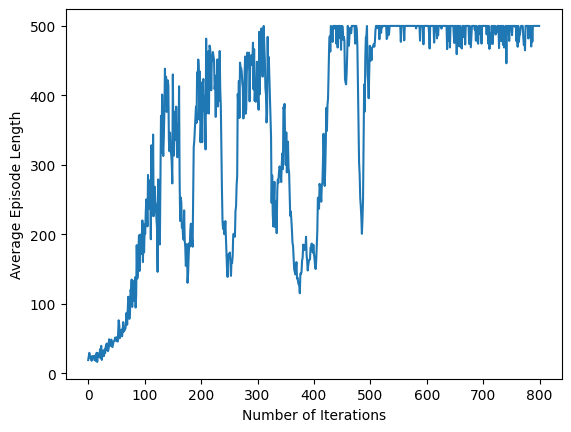

In [9]:
plt.plot(avg_episode_lengths)
plt.xlabel("Number of Iterations")
plt.ylabel("Average Episode Length")
plt.show()

done at step 499


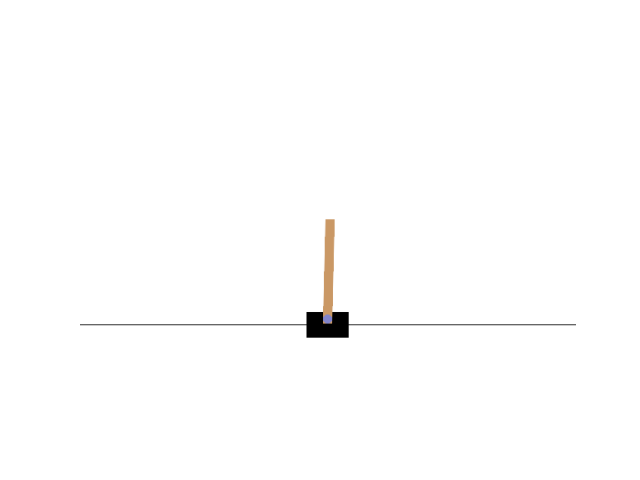

In [10]:
@torch.no_grad()
def sample_action(obs):
    left_proba = pi(torch.as_tensor(obs[np.newaxis], device=config.device)).squeeze().item()
    return int(random.random() > left_proba)

%matplotlib ipympl
show_one_episode(sample_action, repeat=False, n_max_steps=500)